In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('E:\SnehaWork\AIProject\Dataset\Customer-Churn.csv')

In [3]:
Churned = df[df.Churn == 'Yes']
NonChurned = df[df.Churn == 'No']

number_of_Churned = len(Churned)
number_of_NonChurned = len(NonChurned)

Churned_percentage = round((number_of_Churned / (number_of_Churned + number_of_NonChurned)) * 100, 2)
valid_percentage = round((number_of_NonChurned / (number_of_Churned + number_of_NonChurned)) * 100, 2)
print(number_of_NonChurned,number_of_Churned)
df.columns.tolist()

5174 1869


['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [4]:
#df.dtypes
#count yes and no on base data, train and test

In [5]:
df.drop('customerID',axis='columns',inplace=True)

In [6]:
#error='coerce' ignores the errors. Conversion for all except for error values i.e. empty spaces. 
#.isnull() gives columns which have empty spaces
#shows the data which has TotalCharges as null. Good to drop these

df[pd.to_numeric(df.TotalCharges,errors='coerce').isnull()].shape

(11, 20)

In [7]:
#Drop rows with TotalCharges as null

df1 = df[df.TotalCharges!=' ']

In [8]:
df1.TotalCharges = pd.to_numeric(df1.TotalCharges)

C:\Users\USER\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [9]:
df1.replace('No internet service','No',inplace=True)
df1.replace('No phone service','No',inplace=True)

C:\Users\USER\Anaconda3\lib\site-packages\pandas\core\frame.py:4263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [10]:
#replace Yes/No to 1/0 since ML doesn't understand text

yes_no_columns = ['Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
                  'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Churn']

for col in yes_no_columns:
    df1[col].replace({'Yes': 1,'No': 0},inplace=True)

C:\Users\USER\Anaconda3\lib\site-packages\pandas\core\generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [11]:
df1['gender'].replace({'Male':1,'Female':0},inplace=True)

In [12]:
#One hot encoding for multiclass i.e. InternetService, Contract, PaymentMethod

multiclass_col=['InternetService', 'Contract', 'PaymentMethod']
df1 = pd.get_dummies(data=df1,columns=multiclass_col)

In [13]:
#scaling the values between 1 and 0 for below
cols_to_scale = ['tenure','MonthlyCharges','TotalCharges']

#MinMaxScaler scales the data between 0 and 1
scaler = MinMaxScaler()

df1[cols_to_scale] = scaler.fit_transform(df1[cols_to_scale])

In [14]:
def print_unique_col_values(df):
    for column in df:
        print(f'{column} : {df[column].unique()}')

In [15]:
print_unique_col_values(df1)

gender : [0 1]
SeniorCitizen : [0 1]
Partner : [1 0]
Dependents : [0 1]
tenure : [0.         0.46478873 0.01408451 0.61971831 0.09859155 0.29577465
 0.12676056 0.38028169 0.85915493 0.16901408 0.21126761 0.8028169
 0.67605634 0.33802817 0.95774648 0.71830986 0.98591549 0.28169014
 0.15492958 0.4084507  0.64788732 1.         0.22535211 0.36619718
 0.05633803 0.63380282 0.14084507 0.97183099 0.87323944 0.5915493
 0.1971831  0.83098592 0.23943662 0.91549296 0.11267606 0.02816901
 0.42253521 0.69014085 0.88732394 0.77464789 0.08450704 0.57746479
 0.47887324 0.66197183 0.3943662  0.90140845 0.52112676 0.94366197
 0.43661972 0.76056338 0.50704225 0.49295775 0.56338028 0.07042254
 0.04225352 0.45070423 0.92957746 0.30985915 0.78873239 0.84507042
 0.18309859 0.26760563 0.73239437 0.54929577 0.81690141 0.32394366
 0.6056338  0.25352113 0.74647887 0.70422535 0.35211268 0.53521127]
PhoneService : [0 1]
MultipleLines : [0 1]
OnlineSecurity : [0 1]
OnlineBackup : [1 0]
DeviceProtection : [0 1]
Tech

In [16]:
#Drop churn 
x = df1.drop('Churn',axis=1)  #check axis=0/1
y = df1['Churn']
y.value_counts()

0    5163
1    1869
Name: Churn, dtype: int64

In [17]:
#test and train split. 80% for training and 20% for test

X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=5)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=5)

In [19]:
y_train.value_counts()

0    3329
1    1171
Name: Churn, dtype: int64

In [20]:
y_val.value_counts()

0    835
1    290
Name: Churn, dtype: int64

In [21]:
y_test.value_counts()

0    999
1    408
Name: Churn, dtype: int64

In [22]:
num_of_cols = len(x.columns)
num_of_cols

26

In [23]:
X_train=X_train.values.reshape(X_train.shape[0],num_of_cols, 1).astype('float32') 
X_test=X_test.values.reshape(X_test.shape[0],num_of_cols, 1).astype('float32')
X_val=X_val.values.reshape(X_val.shape[0],num_of_cols, 1).astype('float32')

#sometimes works as X_val.values.reshape(X_val.shape[0],26, 1).astype('float32')

In [24]:
X_test.shape

(1407, 26, 1)

In [25]:
X_val.shape

(1125, 26, 1)

In [26]:
X_train.shape

(4500, 26, 1)

In [27]:
Name = "CNN_{}".format(int(time.time())) 
log_dir="E:\\SnehaWork\\AIProject\\TF_Logs\\{}".format(Name)
cnn = models.Sequential([
    layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(26,1)),  
    layers.MaxPooling1D(pool_size=3),
    
    layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=3),
    
    layers.Flatten(),
    layers.Dense(20, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

#cnn.summary()
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=0)

cnn.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

cnn.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=375,epochs=70, callbacks=[tb_callback])

Train on 4500 samples, validate on 1125 samples
Epoch 1/70
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.5958 - accuracy: 0.7064 - val_loss: 0.5617 - val_accuracy: 0.7422
Epoch 2/70
4500/4500 [==============================] - 2s 415us/sample - loss: 0.5543 - accuracy: 0.7398 - val_loss: 0.5395 - val_accuracy: 0.7422
Epoch 3/70
4500/4500 [==============================] - 2s 494us/sample - loss: 0.5266 - accuracy: 0.7398 - val_loss: 0.5071 - val_accuracy: 0.7422
Epoch 4/70
4500/4500 [==============================] - 2s 459us/sample - loss: 0.4909 - accuracy: 0.7456 - val_loss: 0.4726 - val_accuracy: 0.7591
Epoch 5/70
4500/4500 [==============================] - 3s 570us/sample - loss: 0.4596 - accuracy: 0.7764 - val_loss: 0.4559 - val_accuracy: 0.7822
Epoch 6/70
4500/4500 [==============================] - 2s 438us/sample - loss: 0.4469 - accuracy: 0.7829 - val_loss: 0.4458 - val_accuracy: 0.7849
Epoch 7/70
4500/4500 [==============================] - 2s 361us/

In [28]:
cnn.evaluate(X_test,y_test,batch_size=375)

1407/1407 [==============================] - 1s 406us/sample - loss: 0.4698 - accuracy: 0.7733


[0.4698187781930732, 0.77327645]

In [29]:
yp = cnn.predict(X_test)
#yp[:5]

In [30]:
#converting decimal into 0 and 1
y_pred = []
for i in yp:
    if i>0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [31]:
#y_pred[:10]

In [32]:
#y_test[:10]

In [33]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       999
           1       0.68      0.41      0.51       408

    accuracy                           0.77      1407
   macro avg       0.74      0.67      0.68      1407
weighted avg       0.76      0.77      0.75      1407



<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[919,  80],
       [239, 169]])>

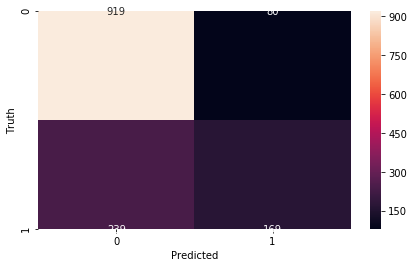

In [34]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred)

plt.figure(figsize = (7,4))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
tf.math.confusion_matrix(labels=y_test,predictions=y_pred)

In [35]:
#conda install tensorboard


In [36]:
%load_ext tensorboard
%tensorboard --logdir log_dir
#The tensorboard extension is already loaded. To reload it, use:
#%reload_ext tensorboard
#%tensorboard --logdir log_dir

#taskkill /F /PID 15092

Reusing TensorBoard on port 6006 (pid 15092), started 3 days, 20:38:59 ago. (Use '!kill 15092' to kill it.)

In [37]:
X_train

array([[[1.],
        [0.],
        [1.],
        ...,
        [0.],
        [1.],
        [0.]],

       [[0.],
        [0.],
        [1.],
        ...,
        [0.],
        [1.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]],

       [[0.],
        [0.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32)